
<h2>
Vinícius S. Brandão - Chargeback Detection
</h2>

<!-- *This project was developed to tackle the requirements on the pdf version of the challenge, some of the github's requirements were addressed, but they were largely an afterthought, tackling both would be too complex for the span of a week. For this reason, this project will not work with payloads, it will merely emulate this on the [Testing implementation section](#implementation)* -->
Este notebook foi editado, pois originalmente fazia parte de um teste técnico no qual fui aprovado. No entanto, não desejo que haja menção direta à empresa envolvida. Portanto, se o conteúdo parecer de difícil compreensão, isso se deve ao fato de que o notebook foi adaptado para responder às perguntas do teste.

This notebook is very long and goes deep in every topic, so for a more straight to the point answer, check the [Conclusion section by clicking here](#conclusion) or scrolling to the bottom. There, each point of item 3 from the challenge is answered directly.


To solve the technical part of this challenge, the chosen tool was Python.<br/>This Python notebook has a structured approach to solve the problems, as follows:
<ul>
<li>
<span style='color:orange'>Intent: </span>Clearly state what is desired or possible.</li>
<li><span style='color:orange'>
Code:  </span>Implement to extract desired information or results. With commented steps.
</li>
<li><span style='color:orange'>
Output & Analysis:  </span>Interpret and analyze the results in relation to the intended outcomes.
</li>
</ul>


<h3 >First preparations</h3>
Before the implementation to our solution, it is important to import all the tools used to solve the problem. 

In this kind of problem, it is important that before we start developing any kind of solution, that we have a good understanding of what kind of information the dataset contains, if it is complete and ig the all information for all the rows are filled in. This allows us to better develop a fitting solution that will be reliable and practical.

In [291]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import StandardScaler

<h2  style='color:#ED7261'>Project Setup</h2>

The first thing to be done is trying to pull out useful data from the dataset before procceding to model creation or other solution implementation.

In the two following cells, the data is pulled from the csv archive, data integrity is verified and adressed, the transaction time is transformed to a usable shape (converted from string/timestap to integer) and a new column is added with the hours regardless of date.

In [292]:
dataset = pd.read_csv('transactions.csv')

def clean_card_number(card):
    return int(''.join(filter(str.isdigit, card)))
dataset['card_number'] = dataset['card_number'].apply(clean_card_number)

# Convert 'transaction_date' to datetime
dataset['transaction_date'] = pd.to_datetime(dataset['transaction_date'])

# Extract hour and minute components separately
# And Combine hour and minute components into a single integer
dataset['transaction_hour'] = dataset['transaction_date'].dt.hour.astype(int)
dataset['transaction_minute'] = dataset['transaction_date'].dt.minute.astype(int)
dataset['transaction_hour_minute'] = dataset['transaction_hour'] * 100 + dataset['transaction_minute']

# Drop the separate hour and minute columns for irrelevancy
dataset.drop(columns=['transaction_hour', 'transaction_minute'], inplace=True)



dataset['transaction_date'] = dataset['transaction_date'].astype(int)

print(dataset.head(1))



   transaction_id  merchant_id  user_id  card_number     transaction_date  \
0        21320398        29744    97051   4345059116  1575242192812632000   

   transaction_amount  device_id  has_cbk  transaction_hour_minute  
0              374.56   285475.0    False                     2316  


In [293]:
print('Transações legítimas (FALSE) vs Fraudes (TRUE):')
print(dataset['has_cbk'].value_counts())

print()
print('Integridade de dados:')
missing_values = dataset.isnull().sum()
print(missing_values)

# Changes the missing device ids to 0
dataset['device_id'] = dataset['device_id'].fillna(0)


Transações legítimas (FALSE) vs Fraudes (TRUE):
False    2808
True      391
Name: has_cbk, dtype: int64

Integridade de dados:
transaction_id               0
merchant_id                  0
user_id                      0
card_number                  0
transaction_date             0
transaction_amount           0
device_id                  830
has_cbk                      0
transaction_hour_minute      0
dtype: int64


The outputted information tells us that:

There are a total of 3199 transactions, with 391 (12%) identified as fraudulent and 2808 (88%) categorized as legitimate transactions.

Additionally, there are 830 transactions where the device ID is missing. These entries cannot be disregarded as they represent genuine usage data. To address this issue, a workaround was implemented: missing device IDs will be replaced with the device ID "0".

Upon manual inspection of the dataset, it was discovered that 67 out of the 830 transactions lacking device IDs (8%) were fraudulent. This suggests that the absence of device IDs does not appear to have a significant impact on the occurrence of fraud upon initial examination.


## <a id='ana'></a>

<h2  style='color:#ED7261' id='data'>Data analysis</h2>
In the next step, we aim to further investigate the patterns in our dataset, using any analytical tools that could provide valuable insight for our application.

First a confusion matrix will be employed to allow us to estimate what are the most important features to be analyzed. This will be started by grouping transactions with common traits and analyzing how the traits relate to each other.

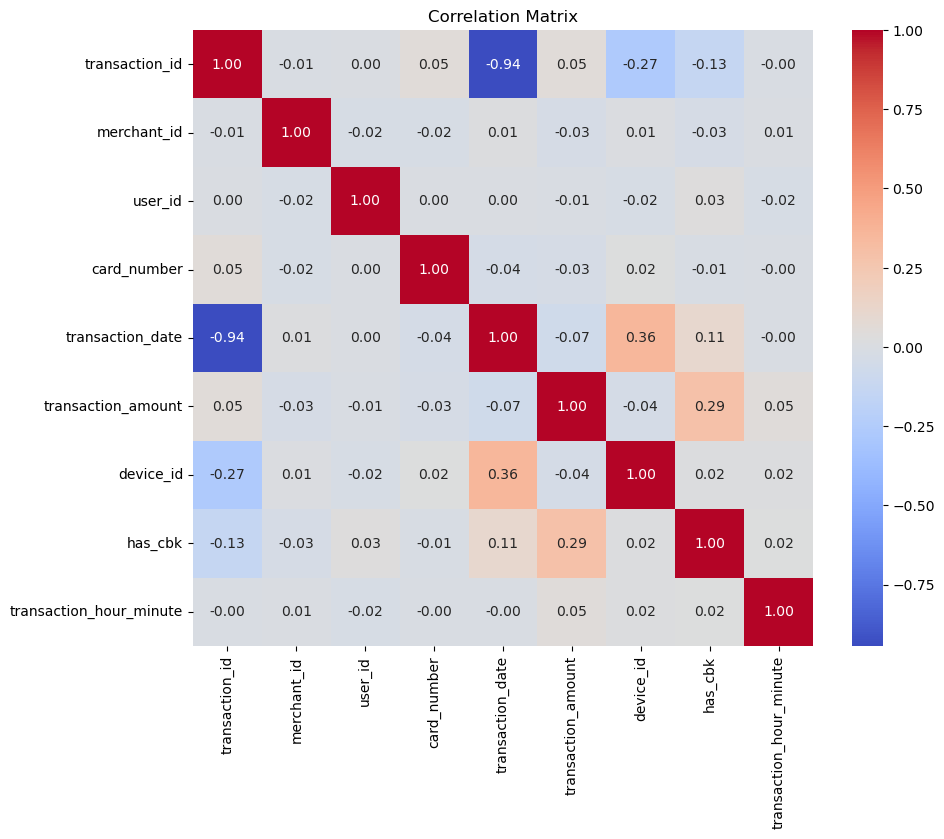

In [294]:
corr_matrix = dataset.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

From the correlation analysis, it is evident that <span style='color:orange'>most of the characteristics exhibit a weak correlation with the variable indicating fraudulent transactions</span>, labeled as "has_cbk". 

The characteristics with stronger correlation are transaction id (that will not be analyzed, because it is unique to each transaction), transaction amount and transaction date that will be analyzed in the form of transaction_hour_minute, user id will also be analyzed as a counterpart to card_id to determine if there are users utilizing multiple cards. Although merchant ID could potentially yield valuable recurrent data, it will not be explored for this project.

Now that we have seen the correlation, the next cells and graphs will explore the groups.
<ul>
<li>
The first grouping will be based on device ID.
</li>
<li>
The second grouping will be by card number.
</li>
<li>
The third grouping will be by transaction amount.
</li>
<li>
Lastly, we'll explore groups based on transaction time.
</li>
</ul>

<h4>1 - Device id</h4>

Number of registered devices:
1997



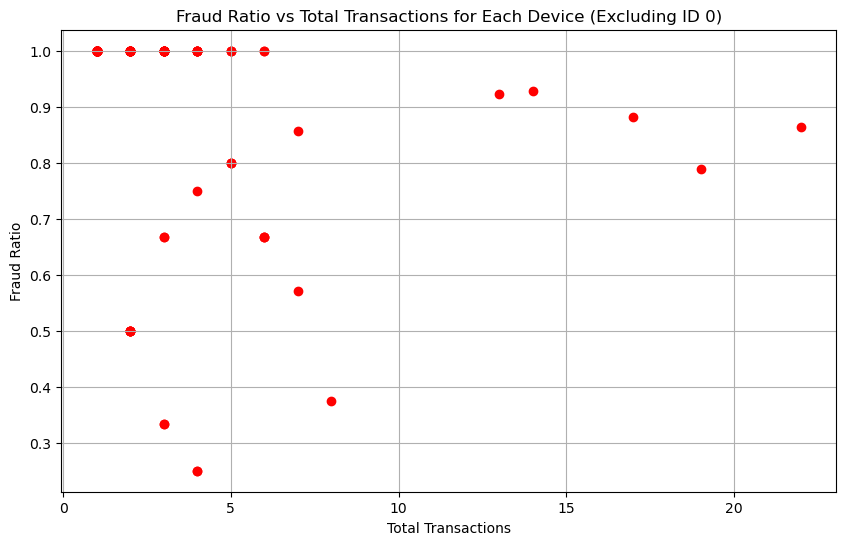

In [295]:

grouped_devices = dataset.groupby('device_id').size()
print('Number of registered devices:')
print(grouped_devices.__len__())
print()

# Calculate the total registered transactions for each card
total_transactions_by_device = grouped_devices

# Find where a fraud occurred and count occurrences
fraud_occurrences = dataset[dataset['has_cbk'] == True]
count = fraud_occurrences.shape[0]

# Calculate the count of fraud occurrences for each card
fraud_occurrences_by_device = fraud_occurrences.groupby('device_id').size()

# Compare fraud occurrences to registered transactions for each card
fraud_ratio_by_device = fraud_occurrences_by_device / total_transactions_by_device


# There are 830 devices with ID 0, so they were removed not to skew the graph. 
filtered_total_transactions = total_transactions_by_device[total_transactions_by_device.index != 0]
filtered_fraud_ratio = fraud_ratio_by_device[total_transactions_by_device.index != 0]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(filtered_total_transactions, filtered_fraud_ratio, color='r')
plt.xlabel('Total Transactions')
plt.ylabel('Fraud Ratio')
plt.title('Fraud Ratio vs Total Transactions for Each Device (Excluding ID 0)')

plt.grid(True)
plt.show()



Upon analyzing the number of transactions by device ID and their corresponding fraud ratios, it becomes evident that when a device has <span style='color:orange'>more than 10 transactions</span>, the likelihood of fraud is significantly high, approaching <span style='color:orange'>nearly 100%</span> in all cases observed. However, when a device has fewer than 10 transactions registered, it is difficult to draw definitive conclusions beyond acknowledging the presence of frauds within this subset.

<h4>2 - Card number</h4>

In [296]:
grouped_transactions = dataset.groupby('card_number').size()
print('registered transactions:')
print(grouped_transactions)
print()


# Print the amount of occurrences of fraud
print("Occurrences of 'fraud':")
# print(occurrences)
print("Count of occurrences:", count)

# print the amount of frauds of each card
grouped_frauds = fraud_occurrences.groupby('card_number').size()
print(grouped_frauds)



registered transactions:
card_number
45938330       1
50677590       1
230744950      1
404024820      1
406655470      1
              ..
6550066876     1
6550077278     1
23074410000    1
44152410003    1
45321110004    1
Length: 2925, dtype: int64

Occurrences of 'fraud':
Count of occurrences: 391
card_number
230744950     1
515590820     1
606282450     1
2306505729    1
2307444802    2
             ..
6504864290    1
6505167004    1
6505169201    3
6507275418    3
6516532256    5
Length: 274, dtype: int64


In [297]:
# Calculate the total registered transactions for each card
total_transactions_by_card = grouped_transactions

# Calculate the count of fraud occurrences for each card
fraud_occurrences_by_card = fraud_occurrences.groupby('card_number').size()

# Compare fraud occurrences to registered transactions for each card
fraud_ratio_by_card = fraud_occurrences_by_card / total_transactions_by_card

fraud_ratio_by_card = fraud_ratio_by_card.fillna(0)

# Print the fraud ratio for each card
print("Fraud ratio for each card:")
print(fraud_ratio_by_card)


Fraud ratio for each card:
card_number
45938330       0.0
50677590       0.0
230744950      1.0
404024820      0.0
406655470      0.0
              ... 
6550066876     0.0
6550077278     0.0
23074410000    0.0
44152410003    0.0
45321110004    0.0
Length: 2925, dtype: float64


In the last two cells, we can see that there are <span style='color:orange'>2925 cards</span> on the database and <span style='color:orange'>274 of those have registered fraudulent transactions</span>. So there is no significant individual card history to be analyzed to track spending habits and do an individual card fraud analysis.

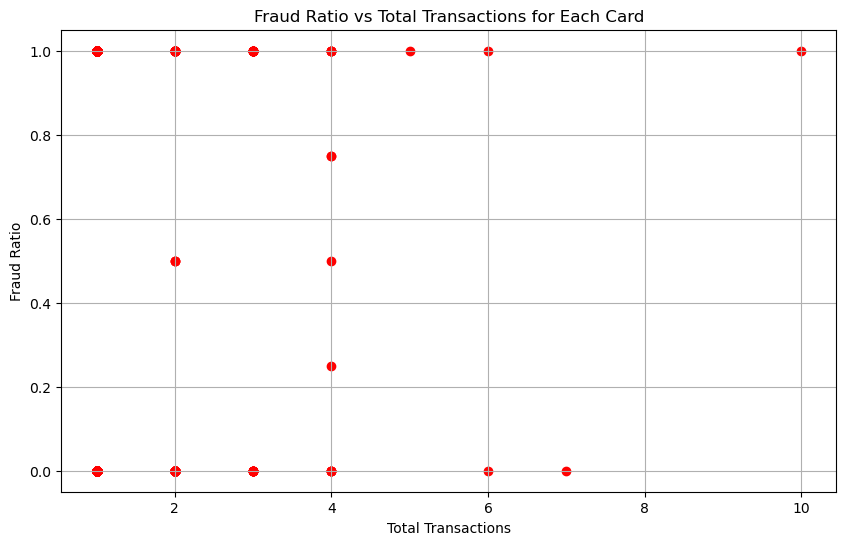

In [298]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(total_transactions_by_card, fraud_ratio_by_card, color='r')
plt.xlabel('Total Transactions')
plt.ylabel('Fraud Ratio')
plt.title('Fraud Ratio vs Total Transactions for Each Card')



plt.grid(True)
plt.show()



This graph shows us that the number of registered transactions is <span style='color:indianred'>not particularly telling of fraud</span>. But, it is noteworthy that as the device id data showed us, if more than 10 transactions are linked to the same entity, this migh be a strong sign of fraud. So it is necessary to find other methods that might help us find a pattern.

<h4>3 - Transaction Amount</h4>

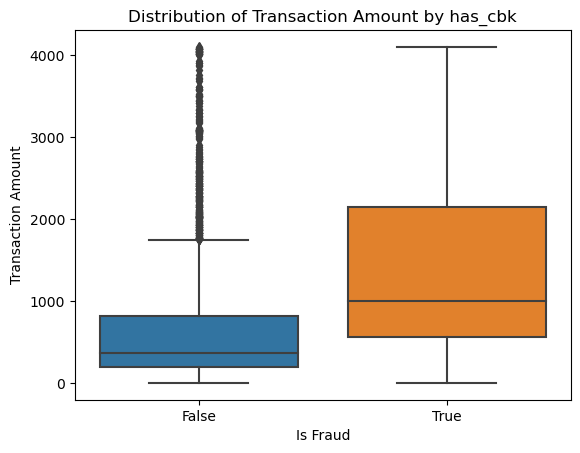

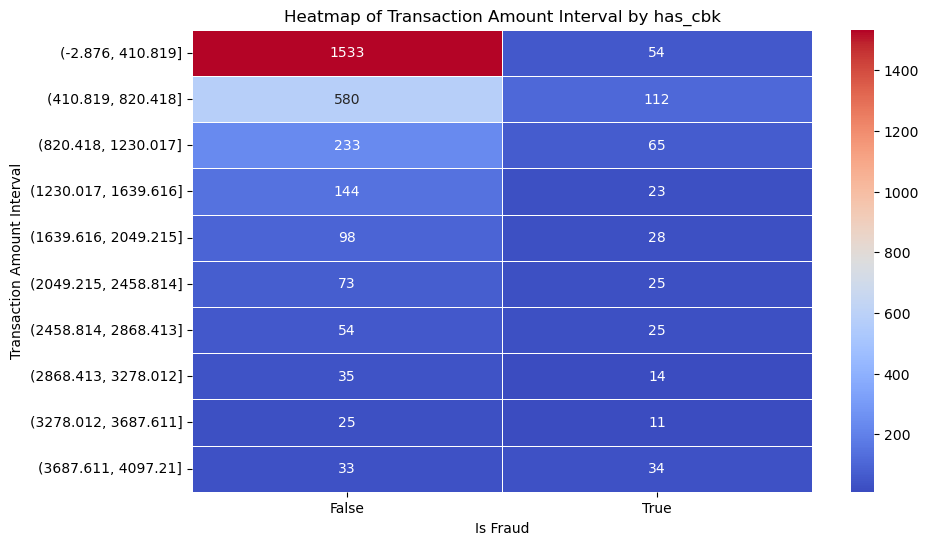

In [299]:

sns.boxplot(x='has_cbk', y='transaction_amount', data=dataset)
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount')
plt.title('Distribution of Transaction Amount by has_cbk')
plt.show()

num_intervals = 10
dataset['transaction_amount_interval'] = pd.cut(dataset['transaction_amount'], bins=num_intervals)

plt.figure(figsize=(10, 6))
heatmap_data = dataset.pivot_table(index='transaction_amount_interval', columns='has_cbk', aggfunc='size', fill_value=0)
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='d', linewidths=.5)
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount Interval')
plt.title('Heatmap of Transaction Amount Interval by has_cbk')
plt.show()


The box plot and heatmap suggest that <span style='color:orange'>the transaction amount is typically higher in fraudulent interactions</span>, but there are many outliers that also indicate big amount transactions can be legitimate. So, one viable solution to reduce the amount of fraud would be to raise suspicion of fraud on large amount transactions. And as it will be used latter, if the value exceeds 1700, the likelihood of it being fraud is very high when compared to lower values, because it deviates too much from the standard legitimate transaction values. 

<h4>4 - Time of transaction</h4>
Here is important to notice that the time is an integer so here are some examples of how the hours would be represented:
    
    00:00 (AM)  =>    0
    01:00       =>  100
    09:00       =>  100
    10:00       => 1000
    23:00/11 AM => 2300

In [300]:
# In this cell, we extracted the ratio of fraud in each hour
# and then printed when the most amount of fraud happens

# Round transaction_hour_minute to the nearest 100
dataset['transaction_hour_minute_rounded'] = dataset['transaction_hour_minute'] // 100 * 100

# Calculate the ratio of False to True for each interval
ratio_data = dataset.groupby(['transaction_hour_minute_rounded', 'has_cbk']).size().unstack(fill_value=0)
ratio_data['ratio'] =   ratio_data[True]/ (ratio_data[False] +  ratio_data[True])

# print(ratio_data['ratio'])
sorted_ratio_data = ratio_data.sort_values(by='ratio', ascending=False)
print('Fraud ratio by time of transaction (All - from highest to lowest ratio):')
print(sorted_ratio_data['ratio'])

# Identify consecutive intervals with ratios above the threshold
threshold = 0.10
higher_ratio_clusters = []
current_cluster = []

for index, row in sorted_ratio_data.iterrows():
    if row['ratio'] > threshold:
        current_cluster.append(index)
    else:
        if current_cluster:
            higher_ratio_clusters.append(current_cluster)
            current_cluster = []

# Print the identified higher ratio clusters
print("\nFraud Ratio by time of transaction (Higher than 10%):")
for cluster in higher_ratio_clusters:
    print(cluster)


Fraud ratio by time of transaction (All - from highest to lowest ratio):
transaction_hour_minute_rounded
600     0.500000
200     0.295082
2300    0.198864
2100    0.185022
0       0.180451
2200    0.177914
1900    0.167939
2000    0.136029
300     0.133333
100     0.126126
1700    0.114391
1600    0.107914
1800    0.082734
1200    0.081081
1500    0.075314
1400    0.064777
1300    0.056410
1100    0.053763
400     0.000000
1000    0.000000
900     0.000000
800     0.000000
500     0.000000
Name: ratio, dtype: float64

Fraud Ratio by time of transaction (Higher than 10%):
[600, 200, 2300, 2100, 0, 2200, 1900, 2000, 300, 100, 1700, 1600]


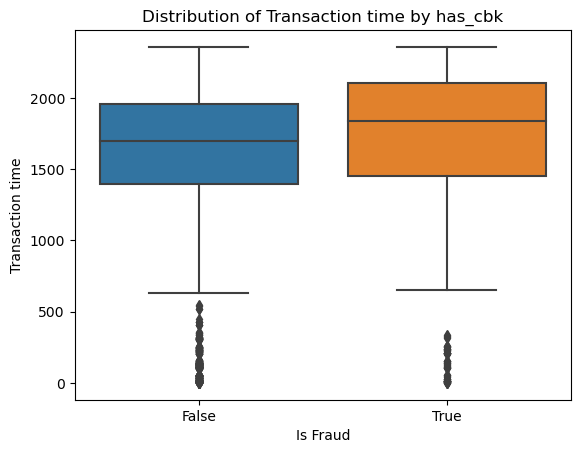

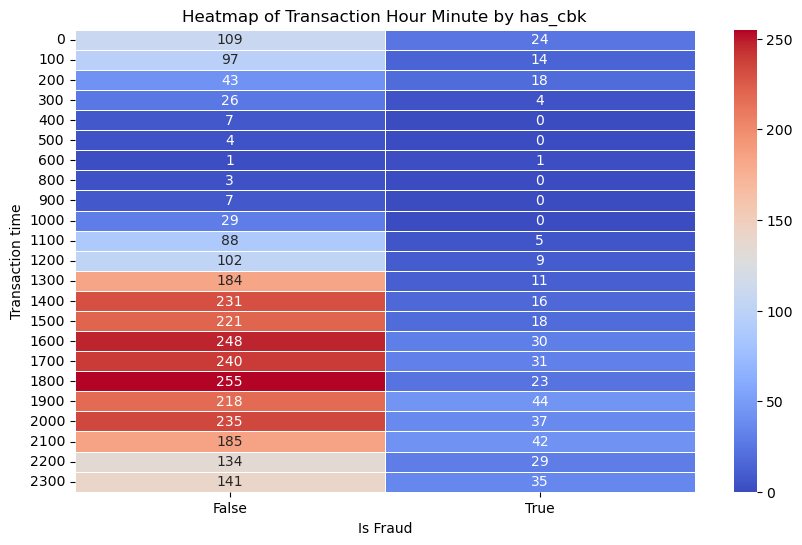

In [301]:

sns.boxplot(x='has_cbk', y='transaction_hour_minute', data=dataset)
plt.xlabel('Is Fraud')
plt.ylabel('Transaction time')
plt.title('Distribution of Transaction time by has_cbk')
plt.show()

dataset['transaction_hour_minute_rounded'] = dataset['transaction_hour_minute'] // 100 * 100

# Create the heatmap
plt.figure(figsize=(10, 6))
heatmap_data = dataset.pivot_table(index='transaction_hour_minute_rounded', columns='has_cbk', aggfunc='size', fill_value=0)
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='d', linewidths=.5)
plt.xlabel('Is Fraud')
plt.ylabel('Transaction time')
plt.title('Heatmap of Transaction Hour Minute by has_cbk')
plt.show()

In this section, we extract more data on what time fraud is more common and when there is a higher ratio of fraud. The graphs show us that the <span style='color:indianred'>most fraudulent occur between 11am and 1am</span> (on the next day), and the fraudulent amount is <span style='color:indianred'>larger than 10% between 4pm and 1am</span>, but it is important to notice that 6am has 50% of fraud ratio. 

<span style='color:indianred'>This is Very useful, since we now know that there is a time period where fraud is more common.</span>

<h4>In context</h4>
This gives us another insight on other potential signs of fraud, if the transaction amount is above 1700 and it occurs between 7 pm and 6 am, it is more probable than a transaction that has a low amount of cash and happens between 6am and 7pm.

From the extracted information, we could define manually rules to determine if a transaction is or is not a fraud.  



## <a id='models'></a>
<h1 id='models' style='color:#ED7261'>DETECTION MODELS</h1>

This problem could be approached from a multitude of ways. It is possible to establish arbitrary criteria to determine what kind of transaction is allowed, an automatic statistical system to autodetect fraud, and many other methods. 

But to do this, it is important to first state the fact that it is impossible to have a 100% accurate method, the <span style='color:orange'>goal is to minimize as best we can the amount of fraud without impeding legitimate transactions</span>. Knowing that false positives and negatives for  are inevitable, we have to optimize to prioritize one over the other. For this project, <span style='color:indianred'>false positives will be prioritized over false negatives</span>, because in this case, false positives would bring more safety to the user and the credit card company at the expanse of inconvenience for the end users.

<h3 style='color:goldenrod'>The chosen solution: Artificial Neural Network</h3>
The chosen method was a neural network, it brought interesting results and a good overall generalization. The hyperparameters and activation functions were tuned, regularization and normalization were applied and the network topology was optimized to bring a good result and have a false positive bias over a false negative one. (the analysis will come after)

The dataset will be separated between training and testing, to show a realistic scenario where it would try to guess from an unlabeled transaction if it was legitimate or not. 

In [302]:
# import and split the data for training and testing the model
X = dataset.drop('has_cbk', axis=1)
y = dataset['has_cbk']

X = X.drop(['transaction_amount_interval'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


The 4 following graphs are to show us the performance that each neural network has. 

A confusion matrix provides a detailed breakdown of classification results, showing correct and incorrect predictions the rows represent the actual classes or labels, while columns represent the predicted classes or labels thus, the main diagonal represents correct classifications. 

RMS loss per epoch graphs track the model's error reduction over training epochs. Both aid in understanding neural network performance quickly and effectively.

And the accuracy tells us the percentage of correct answers the model is getting on the test set.

Accuracy: 88%
Confusion Matrix:
[[531  19]
 [ 59  31]]


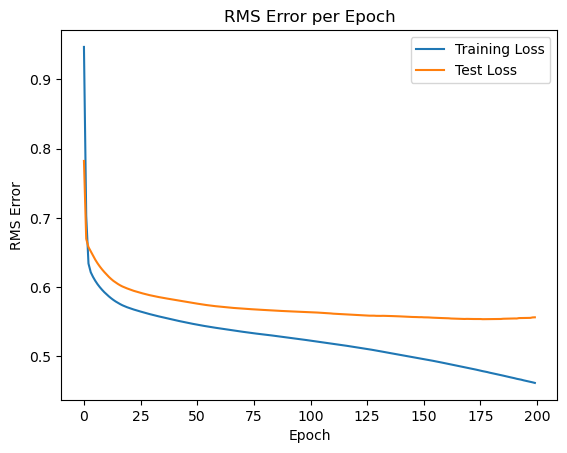

In [303]:
# 200 epch rstate=46

# Define the model
model = MLPClassifier(hidden_layer_sizes=(64, 32, 16, 8), batch_size=50, activation='relu', solver='sgd',
                      max_iter=200, alpha=0.01, learning_rate='adaptive', random_state=46)

# Initialize lists to store training and test losses per epoch
train_loss = []
test_loss = []

# Train the model and collect loss per epoch
for epoch in range(200):
    model.partial_fit(X_train_scaled, y_train, classes=np.unique(y_train))
    train_loss.append(model.loss_)
    
    # Calculate test loss
    y_pred_proba = model.predict_proba(X_test_scaled)
    loss = log_loss(y_test, y_pred_proba)
    test_loss.append(loss)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = model.score(X_test_scaled, y_test)
print(f"Accuracy: {100*accuracy:.0f}%")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting RMS error per epoch
plt.plot(np.sqrt(train_loss), label='Training Loss')
plt.plot(np.sqrt(test_loss), label='Test Loss')
plt.title('RMS Error per Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMS Error')
plt.legend()
plt.show()


Accuracy: 87%
Confusion Matrix:
[[531  19]
 [ 63  27]]


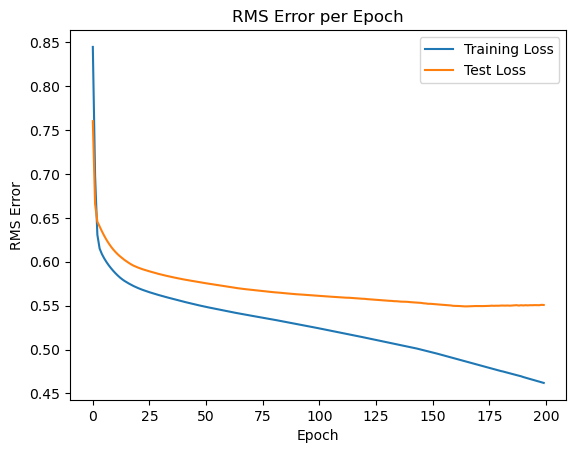

In [304]:
# 200 epch rstate=42

# Define the model
model = MLPClassifier(hidden_layer_sizes=(64, 32, 16, 8), batch_size=50, activation='relu', solver='sgd',
                      max_iter=200, alpha=0.01, learning_rate='adaptive', random_state=42)

# Initialize lists to store training and test losses per epoch
train_loss = []
test_loss = []

# Train the model and collect loss per epoch
for epoch in range(200):
    model.partial_fit(X_train_scaled, y_train, classes=np.unique(y_train))
    train_loss.append(model.loss_)
    
    # Calculate test loss
    y_pred_proba = model.predict_proba(X_test_scaled)
    loss = log_loss(y_test, y_pred_proba)
    test_loss.append(loss)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = model.score(X_test_scaled, y_test)
print(f"Accuracy: {100*accuracy:.0f}%")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting RMS error per epoch
plt.plot(np.sqrt(train_loss), label='Training Loss')
plt.plot(np.sqrt(test_loss), label='Test Loss')
plt.title('RMS Error per Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMS Error')
plt.legend()
plt.show()



Accuracy: 87%
Confusion Matrix:
[[510  40]
 [ 44  46]]


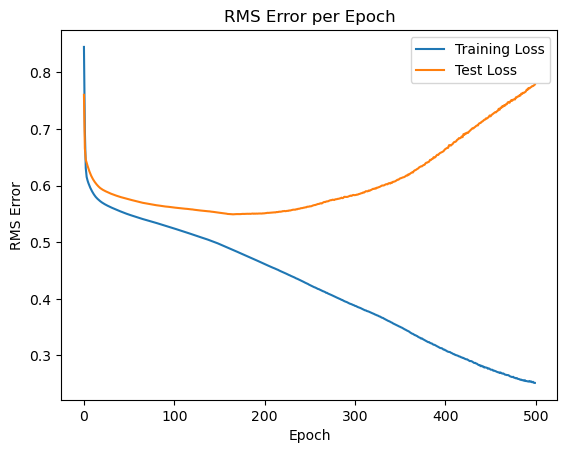

In [305]:
# 500 epch rstate=42

# Define the model
model = MLPClassifier(hidden_layer_sizes=(64, 32, 16, 8), batch_size=50, activation='relu', solver='sgd',
                      max_iter=500, alpha=0.01, learning_rate='adaptive', random_state=42)

# Initialize lists to store training and test losses per epoch
train_loss = []
test_loss = []

# Train the model and collect loss per epoch
for epoch in range(500):
    model.partial_fit(X_train_scaled, y_train, classes=np.unique(y_train))
    train_loss.append(model.loss_)
    
    # Calculate test loss
    y_pred_proba = model.predict_proba(X_test_scaled)
    loss = log_loss(y_test, y_pred_proba)
    test_loss.append(loss)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = model.score(X_test_scaled, y_test)
print(f"Accuracy: {100*accuracy:.0f}%")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting RMS error per epoch
plt.plot(np.sqrt(train_loss), label='Training Loss')
plt.plot(np.sqrt(test_loss), label='Test Loss')
plt.title('RMS Error per Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMS Error')
plt.legend()
plt.show()



Accuracy: 85%
Confusion Matrix:
[[488  62]
 [ 37  53]]


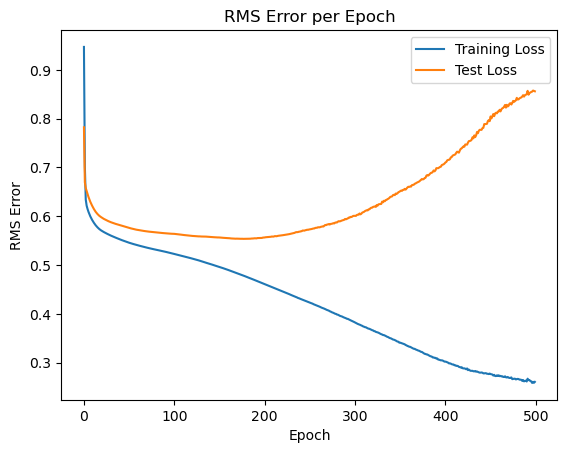

In [306]:
# 500 epch rstate=46

# Define the model
model = MLPClassifier(hidden_layer_sizes=(64, 32, 16, 8), batch_size=50, activation='relu', solver='sgd',
                      max_iter=500, alpha=0.01, learning_rate='adaptive', random_state=46)

# Initialize lists to store training and test losses per epoch
train_loss = []
test_loss = []

# Train the model and collect loss per epoch
for epoch in range(500):
    model.partial_fit(X_train_scaled, y_train, classes=np.unique(y_train))
    train_loss.append(model.loss_)
    
    # Calculate test loss
    y_pred_proba = model.predict_proba(X_test_scaled)
    loss = log_loss(y_test, y_pred_proba)
    test_loss.append(loss)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = model.score(X_test_scaled, y_test)
print(f"Accuracy: {100*accuracy:.0f}%")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


# Plotting RMS error per epoch
plt.plot(np.sqrt(train_loss), label='Training Loss')
plt.plot(np.sqrt(test_loss), label='Test Loss')
plt.title('RMS Error per Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMS Error')
plt.legend()
plt.show()



Four models were trained to compare the effects of tuning on model performance, particularly examining the effects of purposeful overfitting. The parameters were kept consistent across all models.

The models trained with <span style='color:#ED7261'>200 epoch</span> show the better accuracy and loss for the classification in general, when compared to the other models. However, these models struggled to identify potentially fraudulent transactions, misclassifying over 65% of fraud cases as legitimate transactions. Consequently these models would fail to detect most of the irregular behavior, but would be less likely to impede regular transactions.

The models trained with <span style='color:#ED7261'>500 epoch</span>, had a superior capability of detecting frauds, because it was severely overffited and it caused the network to assimilate and memorized the regular transaction patterns. This resulted in more transactions being considered as potentially dangerous, the outliers in the database were classified as fraud. Both networks had more than 50% of success of flagging a fraud as such, this came at the cost of flagging regular transactions that deviate from standard behavior as fraud.

Considering that we have previously determined a preferable outcome as false positives, and the fact that all the models have similar accuracy. <span style='color:orange'>The overfitted (500 epoch) networks are suited better</span> to solve this problem, because it will be better at signaling real frauds than the other models. However, this advantage comes with the tradeoff of increased false positives, as expected. The overfitting takes more time to train because of the increased number of epochs, but once it is implemented, it takes the same time to classify the fed data.



<h2 style='color:orange'>Practical application</h2>
Now we are gonna take the trained model and apply it to a more realistic use case. Some of the data points on the dataset will be taken to test and show the workings of this system.

And then apply the asked for rules in the documentation for this test.

In [307]:
# function to return in a text if a transaction is approved or rejected
def approve(bool):
    if bool==False:
        return ('approve')
    return ('reject')

In [308]:
sample_row = X.iloc[9] 
sample_label = approve(y.iloc[9])

original_sample_row = scaler.transform(sample_row.values.reshape(1, -1))
transaction_id = sample_row['transaction_id'] 
recommendation = approve(model.predict(original_sample_row)[0])

print(f"sample 1:\ntransaction_id: {int(transaction_id)}\nPredicted label for sample 1:{recommendation}\nExpected result: {sample_label}\n")



sample_row2 = X.iloc[1000] 
sample_label2 = approve(y.iloc[1000])

transaction_id2 = sample_row2['transaction_id'] 
original_sample_row2 = scaler.transform(sample_row2.values.reshape(1, -1))
recommendation2 =  approve(model.predict(original_sample_row2)[0])

print(f"sample 2:\ntransaction_id: {int(transaction_id2)}\nPredicted label for sample 1:{recommendation2}\nExpected result: {sample_label2}\n")


sample_row3 = X.iloc[29] 
sample_label3 = approve(y.iloc[29])
transaction_id3 = sample_row3['transaction_id'] 

original_sample_row3 = scaler.transform(sample_row3.values.reshape(1, -1))
recommendation3 =  approve(model.predict(original_sample_row3)[0])


print(f"sample 3:\ntransaction_id: {int(transaction_id3)}\nPredicted label for sample 1:{recommendation3}\nExpected result: {sample_label3}\n")



sample 1:
transaction_id: 21320407
Predicted label for sample 1:reject
Expected result: reject

sample 2:
transaction_id: 21321398
Predicted label for sample 1:approve
Expected result: approve

sample 3:
transaction_id: 21320427
Predicted label for sample 1:approve
Expected result: approve



/usr/lib/python3/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


These results show us that the model works as intended, it will return approve or reject, and be able to do a good generalization on wether or not a transaction should be authorized. But we can do better than this. This is why I will develop further measures to prevent possible frauds. 

## <a id='use'></a>

<h4 style='color:orange' id='use'>Realistic use</h4>

This will be a showcase using a Rule based system following the instructions given on github, emulating what what an actual anti-fraud system would look like. 

For the sake of simplicity and readability, the data won't be passing through the treatment done in the first steps again, but in the real application this would be necessary.

The next Cell contains the antifraud requirements stated in this test's documentation with a brief explanation to the criteria used to determine the logic in the commented code

In [309]:
# first we are gonna create a function to test if a device or user has too many transactions
# If the device or user has 10 or more transactions it will be automatically blocked
# this function will also detect if there was any fraud in the past

def detect_spam(device_id, user_id):
    # This filtering can be adjusted to a certain last x amount of transactions in the registry 
    # We can roughly estimate time based on the amount of transactions pulled from the database
    # if we know the amount of transactions per hour or minute
    device_id_filter = dataset['device_id'].head(3199) == device_id
    device_id_entries = dataset[device_id_filter]
    user_id_filter = dataset['user_id'].head(3199) == user_id
    user_id_entries = dataset[user_id_filter]

    # verify if there is any fraud in history
    has_cbk_in_entries = any(device_id_entries['has_cbk']) or any(user_id_entries['has_cbk'])

      
    if(device_id == 0):
        return False
    elif(has_cbk_in_entries or len(device_id_entries) >= 10 or len(user_id_entries) >=10):
        return True
    
    return False

# Next we are gonna test if the transaction will surpass the time and amount threshold
def detect_large_amount_scam(time, amount):
    # the time out of business hours have over 13% of frauds, for this reason
    # large transactions out of business hours will be flagged as fraud 
    if(time<600 or time>1800):
    #The amount chosen was 1700, because above 1700, more than 30% of the transactions were fraud
        if(amount>1700):
            return True
    return False



The next cell contains a function that will receive a transaction and test it for the rules mandated in the documentation and apply the trained model, <span style='color:orange'>the sequence of the application was chosen by fastest to potentially slowest</span>. The spam detection test, which involves querying a database and thus consumes time proportional to the number of rows checked, is positioned as the slowest test. Meanwhile, the model application sits in the middle in terms of speed, as it is pre-trained and executes basic functions. Finally, the detect_large_amount_scam test is the fastest, as it simply checks for specific conditions.

In [310]:
def test_fraud(transaction):
    transaction_id = sample_row['transaction_id'] 
    device_id = sample_row['device_id']
    user_id = sample_row['user_id'] 
    amount = sample_row['transaction_amount'] 
    time = sample_row['transaction_hour_minute'] 


    is_large_and_late = detect_large_amount_scam(time, amount)
    if(is_large_and_late):
        return ( [int(transaction_id), 'reject', 'Reason: This amount cannot be traded out of business hours.'])

    
    # the scaler has to be properly set, otherwise the model wil no be able to predict the label 
    original_sample_row = scaler.transform(transaction.values.reshape(1, -1))
    recommendation = model.predict(original_sample_row)[0]
    if(recommendation):
         return( [int(transaction_id), 'reject', 'Reason: Our AI system has detected suspicious activity.'])
    
    is_spam = detect_spam(device_id, user_id)

    if(is_spam):
            return ( [int(transaction_id), 'reject', 'Reason: User has done too many transactions in a short period.'])
    
    return ( [int(transaction_id), 'approve', 'Transaction successful'])

## <a id='implementation'></a>
<h4 id='implementation' style='color:orange'>Testing the implementation</h4>
Here we have some samples of possible outcomes, bur not every possible outcome is represented in the provided samples.

The output is done in a semantic manner to better understand what happened to each test.

In [311]:
sample_row = X.iloc[0] 
sample_label = approve(y.iloc[0])

test_sample1 = test_fraud(sample_row)

print(f"transaction_id: {int(test_sample1[0])}\nThis should be:{sample_label}\nModel + rules Recommendation: {test_sample1[1]}\n{test_sample1[2]}\n")

sample_row = X.iloc[782] 
sample_label = approve(y.iloc[782])

test_sample2 = test_fraud(sample_row)

print(f"transaction_id: {int(test_sample2[0])}\nThis should be:{sample_label}\nModel + rules Recommendation: {test_sample2[1]}\n{test_sample2[2]}\n")

# This transaction was chosen because it has spam in it but would be a false negative by the trained model
sample_row = X.iloc[3] 
sample_label = approve(y.iloc[3])

test_sample3 = test_fraud(sample_row)

print(f"transaction_id: {int(test_sample3[0])}\nThis should be:{sample_label}\nModel + rules Recommendation: {test_sample3[1]}\n{test_sample3[2]}\n")


# This transaction was chosen because it has spam in it but would be a false negative by the trained model
sample_row = X.iloc[56] 
sample_label = approve(y.iloc[56])

test_sample4 = test_fraud(sample_row)

print(f"transaction_id: {int(test_sample4[0])}\nThis should be:{sample_label}\nModel + rules Recommendation: {test_sample4[1]}\n{test_sample4[2]}\n")

transaction_id: 21320398
This should be:approve
Model + rules Recommendation: approve
Transaction successful

transaction_id: 21321180
This should be:reject
Model + rules Recommendation: reject
Reason: Our AI system has detected suspicious activity.

transaction_id: 21320401
This should be:reject
Model + rules Recommendation: reject
Reason: This amount cannot be traded out of business hours.

transaction_id: 21320454
This should be:reject
Model + rules Recommendation: reject
Reason: User has done too many transactions in a short period.



/usr/lib/python3/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<h3 style='color: orange'>results:</h3>
The implementation of extra rules was able to improve the result over the neural network model alone. In the examples above. The results also show that all the rules are working properly.
<ul>
<li>
One of the false negatives of the model was corrected by the spam rule, the slowest method
</li>
<li>
One was rejected by the trained model, slow, but still saving time on the spam checkup
</li>
<li>
One was rejected for being a large transaction amount out of business hours (our determined risk factor for fraud), the fastest method  
</li>
<li>
One was approved, to validate if the system would pass for typical behavior</li>
</ul>

This results show that the applied rules bring more safety for the user and the company at the expanse of more inconvenience in the form of more rejected transactions and overall slower processing time.

It is very important to note that if the data being consulted for spam is <span style='color:orange'>stored in ram instead of HDDs or SSDs, this would significantly decrease latency</span> and transaction approval time. (A tool that could help with this would be redis)

## <a id='conclusion'></a>

<h1 id='conclusion' style='color:#ED7261'>CONCLUSION</h1>


Questions and answers:

1. Analyze the data provided and present your conclusions. What suspicious behaviors did you find? What led you to this conclusion? What actions would you take?

    The data analysis leads us to believe that transactions happening between 4pm and 6 am are the most likely to be fraudulent when combined with a large transaction amount (larger than 2000), as well as multiple (surpassing 10) transactions on the same device or by the same user. This was explored in the  [Data analysis section](#ana) by studying the graphs and tables that presented a larger frequency of fraud when these factors were present. The actions that could be taken were tackled in the [Realistic Use section](#use) where these factors were used as parameters to approve or reject a transaction.


2.  In addition to the spreadsheet data, what other data would you consider to find patterns of possible fraudulent behavior?

    Location data holds significant value in fraud detection, as it can be cross-referenced with historical location data to identify suspicious activities. Establishing a comprehensive historical context for each user, particularly when users are identified by card or device ID, is also useful. Without sufficient transactional context attributed to each user, there may be limitations in gathering transactional data, hindering our ability to establish a comparative framework for identifying normal transactions associated with each card.

3. Considering your conclusions, what would you further suggest in order to prevent frauds and/or chargebacks?

    Considering this, it would be prudent to establish some rules to limit the ability that bad actor have to practice fraud, such as the ones established in the real [Realistic Use section](#use) in the detect_spam and detect_large_amount_scam functions use, so limit transactions that surpass a certain threshold and limit the amount of transactions one can make in a certain period of time. (read commented code to understand the reasoning behind the parameters chosen) 

4. Create a simple anti-fraud.
  
   This notebook was mostly dedicated to solve this, more details can be found on [Detection Models](#models) and [Realistic Use sections](#use), where you find most of the explanation of how the anti-fraud was developed. And a comprehensive example of the anti-fraud system working can be found at the [Testing Implementation section](#implementation). 